# 深層学習を使って手書き数字を認識する

# ライブラリ

## 学習モデルのロードとデータ取得に必要なライブラリ


本ノートブックではTensorFlow 2.15.0で動作保証をしています。

GoogleColaboratoryでは自動的に最新版がインストールされるため、  
下記のセルで現在インストールされているTensorFlowをアンインストールし、動作確認済みのTensorFlow 2.15.0をインストールしている。

In [ ]:
!pip uninstall -y tensorflow
!pip install tensorflow==2.15.0

### 基本処理、画像描画用のライブラリ

In [7]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

import cv2
import os
from IPython.display import clear_output

# 学習データの準備

In [ ]:
from tensorflow.keras.datasets import mnist

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## データの確認
手書き数字画像データ 訓練データの一番目の画像を確認

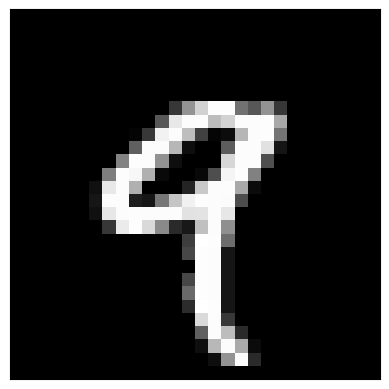

In [ ]:
plt.imshow(x_train[4], cmap="gray")
plt.xticks([]);
plt.yticks([]);
plt.savefig("predict_test.png")

訓練データ一番目の正解ラベルを調べる

In [ ]:
y_train[4]

9

訓練データ先頭の81個の画像を確認する

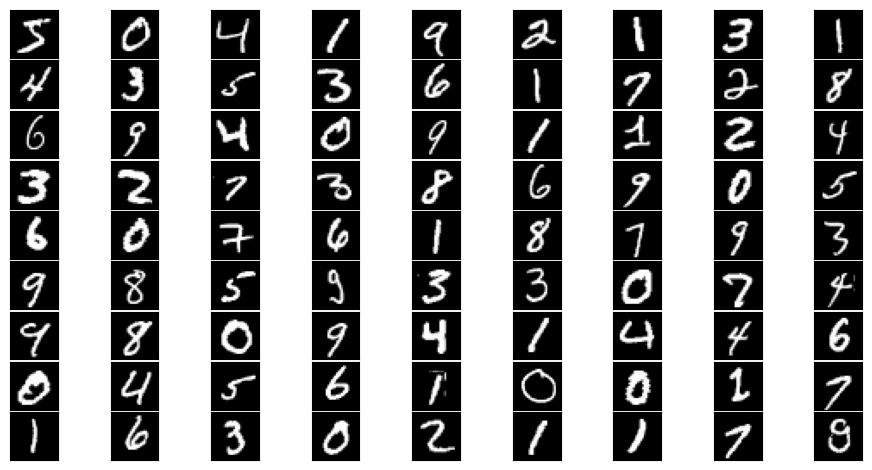

In [ ]:
fig = plt.figure(figsize=(9, 9))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

for i in range(81):
    ax = fig.add_subplot(9, 9, i + 1, xticks=[], yticks=[])
    ax.imshow(x_train[i].reshape(28, 28), cmap="gray")

訓練データの正解ラベルの先頭81個を表示

In [ ]:
y_train[:81]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0,
       9, 1, 1, 2, 4, 3, 2, 7, 3, 8, 6, 9, 0, 5, 6, 0, 7, 6, 1, 8, 7, 9,
       3, 9, 8, 5, 9, 3, 3, 0, 7, 4, 9, 8, 0, 9, 4, 1, 4, 4, 6, 0, 4, 5,
       6, 1, 0, 0, 1, 7, 1, 6, 3, 0, 2, 1, 1, 7, 9], dtype=uint8)

訓練データの正解ラベルのユニークな種別を表示

In [ ]:
import numpy as np

In [ ]:
classes = np.unique(y_train)
classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

画像から識別したいラベルの種類は10種類

In [ ]:
num_classes = len(classes)
num_classes

10

# 深層学習のための準備

### 深層学習用のライブラリ  

In [ ]:
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K

In [ ]:
# input image dimensions
img_rows, img_cols = x_train[0].shape
# 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


# 畳み込みニューラルネットワークの実装

In [ ]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### モデルのサマリー

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 24, 24, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,179,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,199,882 (4.58 MB)

 Trainable params: 1,199,882 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

# モデルのコンパイル

In [ ]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

# 学習データの訓練および検証

## 学習設定

In [ ]:
batch_size = 128
num_classes = 10
epochs = 12

## 学習の実行

In [ ]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - accuracy: 0.1131 - loss: 2.3008 - val_accuracy: 0.2654 - val_loss: 2.2679
Epoch 2/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 12s 7ms/step - accuracy: 0.2056 - loss: 2.2617 - val_accuracy: 0.4007 - val_loss: 2.2188
Epoch 3/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.2940 - loss: 2.2125 - val_accuracy: 0.5164 - val_loss: 2.1539
Epoch 4/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.3675 - loss: 2.1503 - val_accuracy: 0.5942 - val_loss: 2.0665
Epoch 5/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4377 - loss: 2.0624 - val_accuracy: 0.6486 - val_loss: 1.9477
Epoch 6/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.4982 - loss: 1.9447 - val_accuracy: 0.6963 - val_loss: 1.7912
Epoch 7/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5481 - loss: 1.7976 - val_accuracy: 0.7224 - val_loss: 1.6008
Epoch 8/12
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.5841 - loss: 1.6337 - val_accuracy:

# モデルの読み込み
上記学習よりも精度の良い **学習モデル** ファイル（h5形式）を読み込み、手書き数字の推論を行う。

In [2]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array, load_img

## モデルの読み込み

### Google ColabratoryでGitHubリポジトリのモデルを使用するための設定
GoogleDriveに保存した手書き数字画像を推論するための学習済みモデルをロードする

In [3]:
# Google DriveをColabratoryにマウント
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# マウントされたGoogle Driveに作業場所を変更
%cd /content/gdrive/My\ Drive/keras_mnist/mnist_model

/content/gdrive/My Drive/keras_mnist/mnist_model


In [5]:
# モデルの読み込み
model=load_model('MNIST99.h5')

## 推論の実行

name: 8
score: 0.57507217


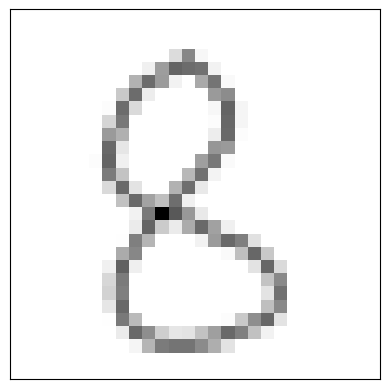

In [9]:
# img_path = 'predict_test.png'
img_path = 'number01.png'
# 数字画像の読み込み
load_image = load_img(img_path, target_size=(28, 28), color_mode="grayscale")
img = img_to_array(load_image)
# 画像のプレビュー
plt.imshow(img.reshape(28,28), cmap="gray")
plt.xticks([])
plt.yticks([])

img_nad = img/255
img_nad = img_nad[None, ...]

# 推論ラベルの設定
label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
# 推論の実行
pred = model.predict(img_nad, batch_size=1, verbose=0)

# 結果の出力
score = np.max(pred)
pred_label = label[np.argmax(pred[0])]
print('name:',pred_label)
print('score:',score)

## 推論システムを関数化

In [10]:
def mnist_predict(img_path, invers=False):
    load_image = load_img(img_path, target_size=(28, 28), color_mode="grayscale")

    img = img_to_array(load_image)
    if invers:
        img = 255 - img
    plt.imshow(img.reshape(28,28), cmap="gray")
    plt.xticks([])
    plt.yticks([])

    img_nad = img/255
    img_nad = img_nad[None, ...]

    label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    pred = model.predict(img_nad, batch_size=1, verbose=0)
    score = np.max(pred)
    pred_label = label[np.argmax(pred[0])]
    print('name:',pred_label)
    print('score:',score)

### 関数の実行

name: 8
score: 0.57507217


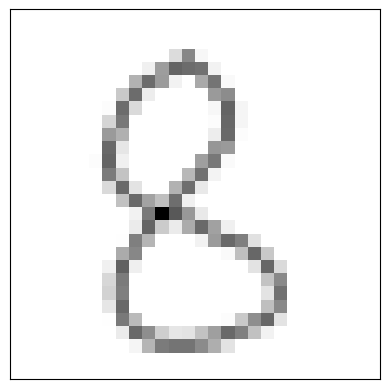

In [11]:
mnist_predict("number01.png")

# インカメラで取った映像をリアルタイムで推論
Google ColaboratoryでPCのWebカメラを使用するための設定を行う。
1. カメラを実行中に行う処理を記述した関数セル
2. カメラを実行してGoolgle Coraboratory上で1.で書いた処理を実行するための関数を記述したセル
3. 関数の実行

参考Webサイト：【簡単】webカメラでAI自動認識! for Google Colab　https://qiita.com/PoodleMaster/items/480b1da080282b15b584

In [12]:
# 1. カメラを実行中に行う処理を記述した関数セル

import IPython
from google.colab import output
from google.colab.patches import cv2_imshow # incompatible with Jupyter notebook
import cv2
import numpy as np
from PIL import Image, ImageDraw
from io import BytesIO
import base64


def mnist_predict_webcam(cv_img, invers=False):
  img = cv2.resize(cv_img, (28, 28))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = Image.fromarray(img)
  img = img_to_array(img)

  if invers:
      img = 255 - img
  img_nad = img/255
  img_nad = img_nad[None, ...]
  label = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
  pred = model.predict(img_nad, batch_size=1, verbose=0)
  score = np.max(pred)
  pred_label = label[np.argmax(pred[0])]
  # print('name:',pred_label)
  # print('score:',score)
  img = cv2.resize(img, (28*7, 28*6)).astype(np.uint8)
  return img, score, pred_label

def run(img_str):
  #decode to image
  decimg = base64.b64decode(img_str.split(',')[1], validate=True)
  decimg = Image.open(BytesIO(decimg))
  decimg = np.array(decimg, dtype=np.uint8);
  decimg = cv2.cvtColor(decimg, cv2.COLOR_BGR2RGB)

  #############your process###############
  decimg = cv2.flip(decimg, 1)
  input_img, score, pred_label = mnist_predict_webcam(decimg)

  # mnist_predict_webcam()
  TXT1 = "predict results"
  TXT2 = "name :" + str(pred_label) + ", score: " + str(score)
  zeros = np.zeros((244, 244), dtype=np.uint8)
  img = Image.fromarray(zeros)
  input_img = Image.fromarray(input_img)
  draw = ImageDraw.Draw(img)
  draw.text((15, 5), TXT1, fill=(255))
  draw.text((15, 15), TXT2, fill=(255))
  img.paste(input_img, (25, 30))
  img = np.array(img)

  out_img = cv2.resize(img, (224*3, 224*3))               # 拡大表示
  #############your process###############

  #encode to string
  _, encimg = cv2.imencode(".jpg", out_img, [int(cv2.IMWRITE_JPEG_QUALITY), 80])
  img_str = encimg.tobytes()
  img_str = "data:image/jpeg;base64," + base64.b64encode(img_str).decode('utf-8')
  return IPython.display.JSON({'img_str': img_str})

output.register_callback('notebook.run', run)

In [13]:
# 2. カメラを実行してGoolgle Coraboratory上で1.で書いた処理を実行するための関数を記述したセル
from IPython.display import display, Javascript
from google.colab.output import eval_js

def use_cam(quality=0.8):
  js = Javascript('''
    async function useCam(quality) {
      const div = document.createElement('div');
      document.body.appendChild(div);
      //video element
      const video = document.createElement('video');
      video.style.display = 'None';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      //canvas for display. frame rate is depending on display size and jpeg quality.
      display_size = 640
      const src_canvas = document.createElement('canvas');
      src_canvas.width  = display_size;
      src_canvas.height = display_size * video.videoHeight / video.videoWidth;
      const src_canvasCtx = src_canvas.getContext('2d');
      src_canvasCtx.translate(src_canvas.width, 0);
      src_canvasCtx.scale(-1, 1);
      div.appendChild(src_canvas);

      const dst_canvas = document.createElement('canvas');
      dst_canvas.width  = src_canvas.width;
      dst_canvas.height = src_canvas.height;
      const dst_canvasCtx = dst_canvas.getContext('2d');
      div.appendChild(dst_canvas);

      //exit button
      const btn_div = document.createElement('div');
      document.body.appendChild(btn_div);
      const exit_btn = document.createElement('button');
      exit_btn.textContent = 'Exit';
      var exit_flg = true
      exit_btn.onclick = function() {exit_flg = false};
      btn_div.appendChild(exit_btn);

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      var send_num = 0
      // loop
      _canvasUpdate();
      async function _canvasUpdate() {
            src_canvasCtx.drawImage(video, 0, 0, video.videoWidth, video.videoHeight, 0, 0, src_canvas.width, src_canvas.height);
            if (send_num<1){
                send_num += 1
                const img = src_canvas.toDataURL('image/jpeg', quality);
                const result = google.colab.kernel.invokeFunction('notebook.run', [img], {});
                result.then(function(value) {
                    parse = JSON.parse(JSON.stringify(value))["data"]
                    parse = JSON.parse(JSON.stringify(parse))["application/json"]
                    parse = JSON.parse(JSON.stringify(parse))["img_str"]
                    var image = new Image()
                    image.src = parse;
                    image.onload = function(){dst_canvasCtx.drawImage(image, 0, 0)}
                    send_num -= 1
                })
            }
            if (exit_flg){
                requestAnimationFrame(_canvasUpdate);
            }else{
                stream.getVideoTracks()[0].stop();
            }
      };
    }
    ''')
  display(js)
  data = eval_js('useCam({})'.format(quality))

下記のセルを初回実行する際、ブラウザからカメラへのアクセス許可を求めらることがあります。
その場合はアクセスを許可してください。

セルはエラーとなりますが、もう一度実行すれば実行に成功します。

In [ ]:
# 3. 関数の実行

use_cam()